<a href="https://colab.research.google.com/github/EmanueleGiavardi/BSP_project/blob/main/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from google.colab import drive
from scipy.fftpack import fft
from sklearn.decomposition import PCA

In [2]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [59]:
#dataset_folder (Drive) = "/content/drive/MyDrive/BSP_Project/set-a-text/"
test_sp = "/content/drive/MyDrive/BSP_Project/set-a-text/a01.csv"

def extract_stochastic_process(filename):
    df = pd.read_csv(filename, skiprows=2, header=None)

    timestamps = df[0]
    stochastic_process = []
    for i in range (1,5):
        AECG = df[i].to_numpy()
        AECG_cleaned = np.where(AECG == '-', '0', AECG)
        stochastic_process.append(AECG_cleaned.astype(float))

    return timestamps, stochastic_process

# t -> timestamp [60 seconds]
# q = 4 channels:
#   S1[0] = -> AECG1
#   S1[1] = -> AECG2
#   S1[2] = -> AECG3
#   S1[3] = -> AECG4

t, SP = extract_stochastic_process(test_sp)
sf = 1000 #sampling frequency

In [33]:
colors = ['blue', 'green', 'orange', 'red']

def plot_AECG(AECG):
    plt.figure(figsize=(14, 6))
    plt.plot(t, AECG)
    plt.title('AECG')
    plt.xlabel('Time [s]')
    plt.ylabel('Magnitude')
    plt.grid(True)
    plt.show()

def plot_fft_magnitude(signal, fs, x_limit=100, y_limit=100000):
    N = len(signal)
    f = np.linspace(0, fs / 2, N // 2)
    fft_values = fft(signal)
    magnitude = np.abs(fft_values[:N // 2])

    plt.figure(figsize=(14, 6))
    plt.plot(f, magnitude)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')
    plt.xlim(0, x_limit)
    plt.ylim(0, y_limit)
    plt.grid()
    plt.show()

def plot_fft_phase(signal, fs):
    N = len(signal)
    f = np.linspace(0, fs / 2, N // 2)
    fft_values = fft(signal)
    phase = np.angle(fft_values[:N // 2])

    plt.figure(figsize=(14, 6))
    plt.plot(f, phase)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Phase')
    plt.grid()
    plt.show()

def plot_stochastic_process(process):
    fig, axes = plt.subplots(4, 1, figsize=(10, 10), sharex=True)

    for i in range(0, 4):
        axes[i].plot(t, process[i], color=colors[i])
        axes[i].set_title(f"AECG{i+1}")

    plt.xlabel("Time (samples)")

    plt.tight_layout()
    plt.show()

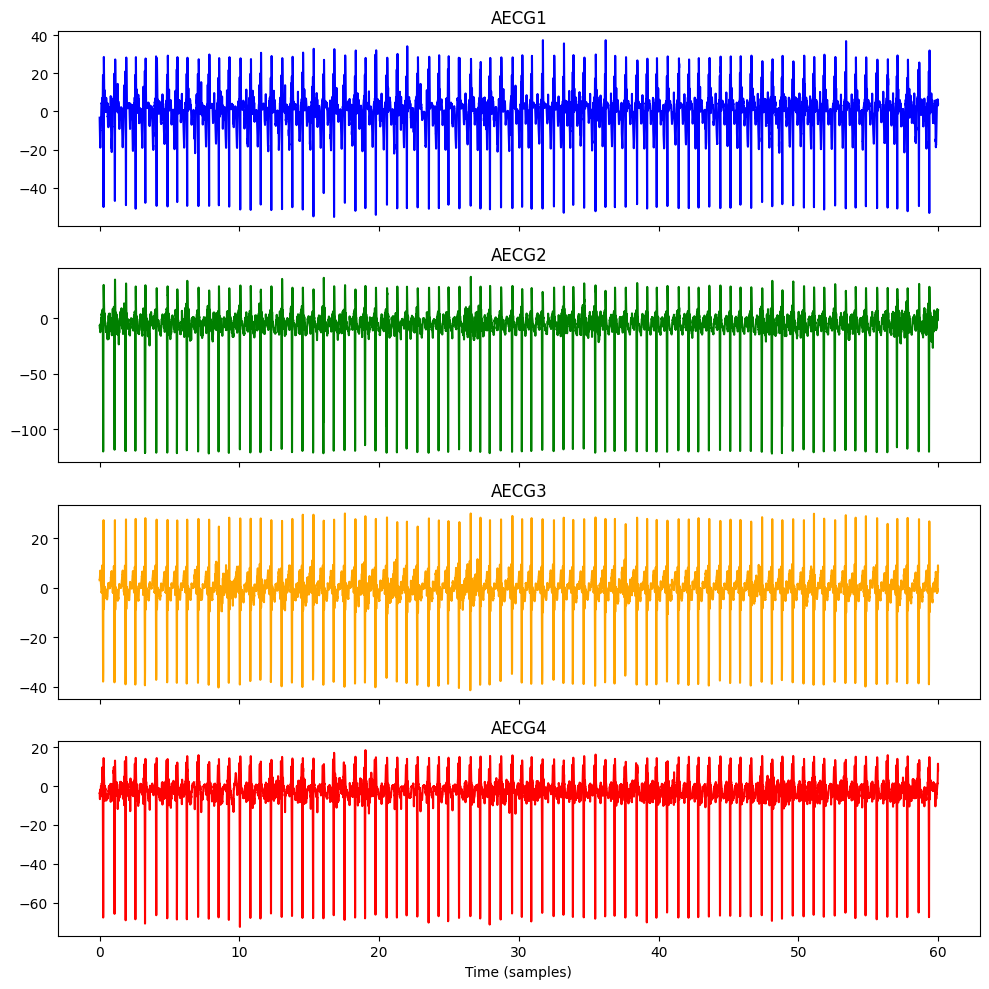

In [34]:
plot_stochastic_process(SP)

# <b>Baseline Wander Remover</b>

#### Linear Phase High-Pass Filter creation (library)

In [36]:
from scipy.signal import firwin, filtfilt

def highpass_fir_filter(signal, sf, cutoff, num_taps=1000):

    nyquist = 0.5 * sf
    cutoff_normalized = cutoff / nyquist

    # crea i coefficienti del filtro (valori del sinc finestrato di lunghezza num_taps)
    fir_coefficients = firwin(num_taps, cutoff_normalized, pass_zero=False)

    # applica la convoluzione tra i valori del sinc finestrato e il segnale
    filtered_signal = filtfilt(fir_coefficients, [1.0], signal)

    return filtered_signal, fir_coefficients


cutoff = 3
# TODO: riguardare perchè + 1
num_taps = 1000


# Applicazione del filtro
#filtered_AECG, fir_coefficients = highpass_fir_filter(AECG1, fs, cutoff, num_taps)

# applicazione del filtro a tutte le realizzazioni del processo
filtered_SP = []
fir_coeffs = []
for AECG in SP:
    filtered_AECG, fir_coefficients =  highpass_fir_filter(AECG, sf, cutoff, num_taps+1)
    filtered_SP.append(filtered_AECG)
    fir_coeffs.append(fir_coefficients)

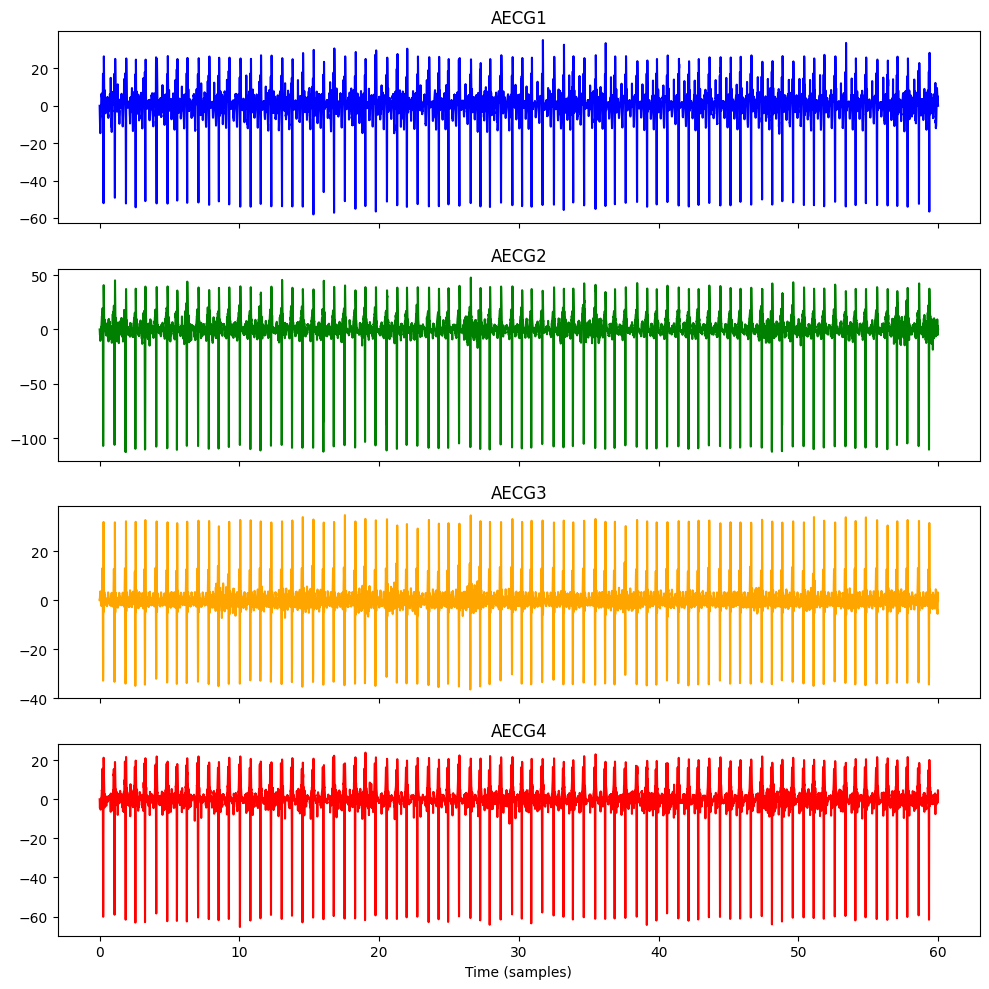

In [37]:
plot_stochastic_process(filtered_SP)

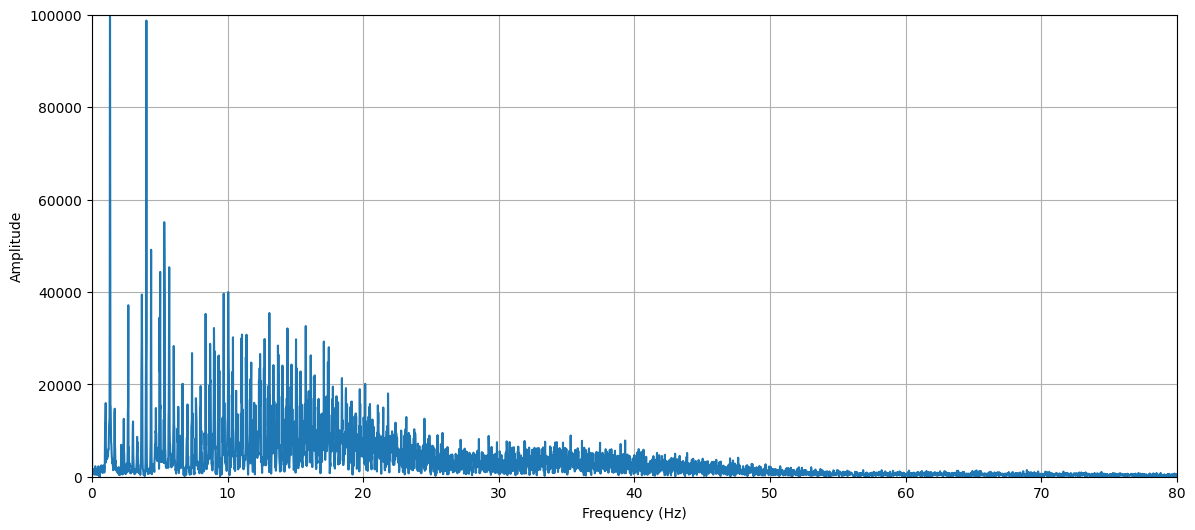

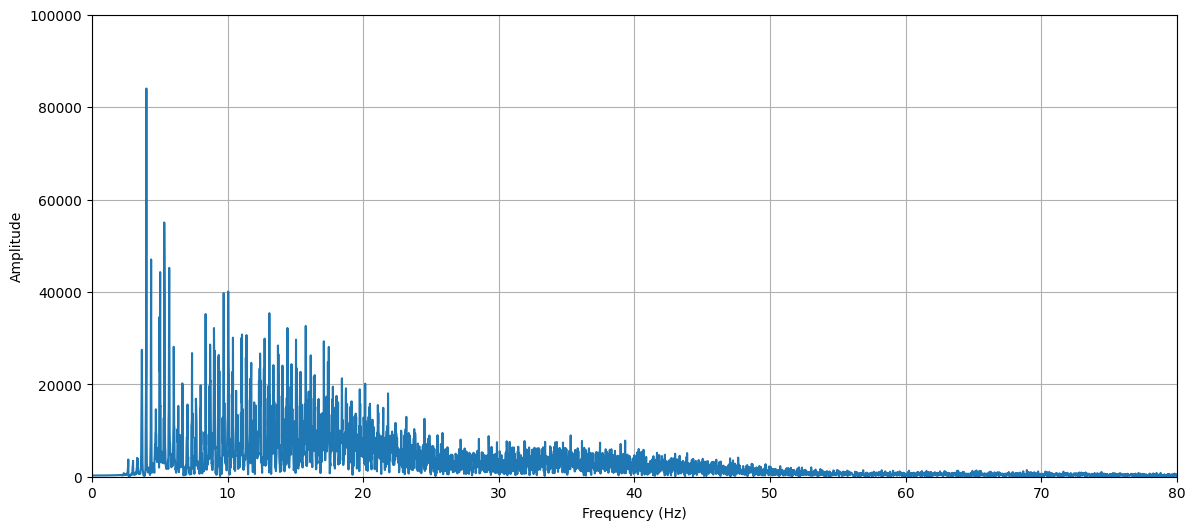

In [43]:
# Spettro del segnale originale
plot_fft_magnitude(SP[0], sf, x_limit=80)

# Spettro del segnale filtrato
plot_fft_magnitude(filtered_SP[0], sf, x_limit=80)

# <b>Power-line interference canceller</b>

per ora troppo complicato, inoltre sembra che gli ECG del dataset abbiano già un filtraggio notch intorno ai 50 Hz per la rimozione della PLI. TODO:
- implementare il metodo ottimizzato proposto nel paper (top)
- implementare il metodo proposto dal paper, semplificato (accettabile)
- usare un notch filter a 50 Hz (brutto)

# **Upsampling ??**

# **Maternal QRS Detector**



### **1) QRS enhancement method**

L'idea è quella di sfruttare la forte correlazione tra le componenti QRS dei vari segnali e la bassa correlazione tra il rumore che li caratterizza, assumendo che ciascuna realizzazione del processo sia caratterizzata da queste due componenti.
Passaggi:

1. Normalizzazione dei canali, dividendo ciascun canale per la sua norma (Euclidea?)
2. Applicazione della PCA sui canali
3. estrazione della prima componente come ECG con complessi QRS rafforzati

Questa procedura genera un segnale $\tilde{x}$ associato alla componente con maggiore varianza



(60000, 4)


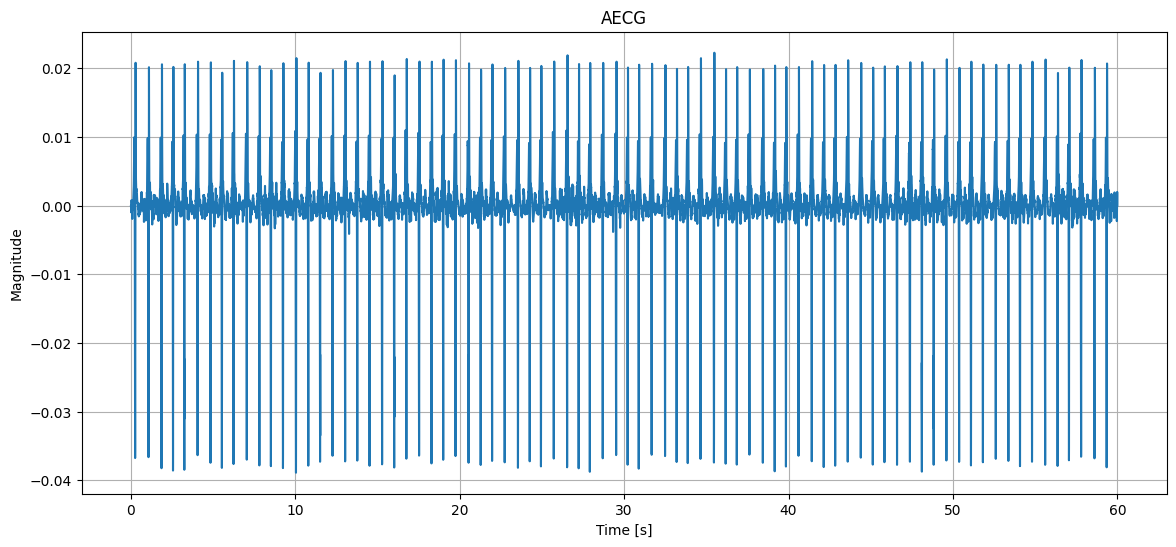

Varianza spiegata dalla prima componente:68%


In [68]:
# Collocazione delle realizzazioni in una matrice X p x q (60000 x 4)
X = np.column_stack([AECG for AECG in filtered_SP])
print(X.shape)

# Normalizzazione
norms = np.linalg.norm(X, axis=0)
X_normalized = X / norms

# PCA
pca = PCA(n_components=1)
pc1 = pca.fit_transform(X_normalized)
Enhanced_QRS = pc1.flatten()

plot_AECG(Enhanced_QRS)

print(f"Varianza spiegata dalla prima componente:{round(pca.explained_variance_ratio_[0]*100)}%")

### **2) QRS detection method**

L'idea qui è quella di usare un template QRS $h(t)$ e di calcolare la cross-correlazione $R_{\tilde{x},h}(τ)$ con il segnale $\tilde{x}$.

I massimi locali (picchi) di $R_{\tilde{x},h}(τ)$ saranno salvati in un vettore `R = [r1, r2, ... , rN]` che identificherà le N posizioni dei picchi QRS della madre